### Data Science Regression Project: Predicting Home Prices in Banglore

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

#### Data Load: Load banglore home prices into a dataframe

In [2]:
df1 = pd.read_csv(r"C:\Users\Hp\Downloads\Bengaluru_House_Data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df1.shape

(13320, 9)

In [4]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [5]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [6]:
df1['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

##### Drop features that are not required to build our model

In [7]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(13320, 5)

#### Data Cleaning: Handle NA values

In [8]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [9]:
df2.shape

(13320, 5)

In [10]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [11]:
df3.shape

(13246, 5)

#### Feature Engineering
#### Add new feature(integer) for bhk (Bedrooms Hall Kitchen)

In [12]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

C:\Users\Hp\AppData\Local\Temp\ipykernel_10584\2716584372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

##### Explore total_sqft feature

In [13]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [14]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple

In [15]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None   

In [16]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850

In [17]:
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [18]:
(2100+2850)/2

2475.0

#### Feature Engineering
##### Add new feature called price per square feet

In [19]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [20]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [21]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

location
Whitefield                           533
Sarjapur  Road                       392
Electronic City                      304
Kanakpura Road                       264
Thanisandra                          235
                                    ... 
Zuzuvadi                               1
Chellikere                             1
Jakkasandra                            1
Gulakamale                             1
Beml layout, Rajarajeshwari nagar      1
Name: count, Length: 1287, dtype: int64

In [22]:
location_stats.values.sum()

np.int64(13200)

In [23]:
len(location_stats[location_stats>10])

240

In [24]:
len(location_stats)

1287

In [ ]:
len(location_stats[location_stats<=10])

#### Dimensionality Reduction
Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [25]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
Ganga Nagar                          10
Kalkere                              10
Dairy Circle                         10
1st Block Koramangala                10
Sector 1 HSR Layout                  10
                                     ..
Zuzuvadi                              1
Chellikere                            1
Jakkasandra                           1
Gulakamale                            1
Beml layout, Rajarajeshwari nagar     1
Name: count, Length: 1047, dtype: int64

In [26]:
len(df5.location.unique())

1287

In [27]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

241

In [28]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


#### Outlier Removal Using Business Logic

In [29]:
df5[df5.total_sqft/df5.size<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [30]:
df5.shape

(13200, 7)

In [31]:
df6 = df5[~(df5.total_sqft/df5.size<300)]
df6.shape

(0, 7)

#### Outlier Removal Using Standard Deviation and Mean

In [32]:
df6.price_per_sqft.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: price_per_sqft, dtype: float64

In [33]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(0, 0)

In [48]:
print(df7.columns)


RangeIndex(start=0, stop=0, step=1)


Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

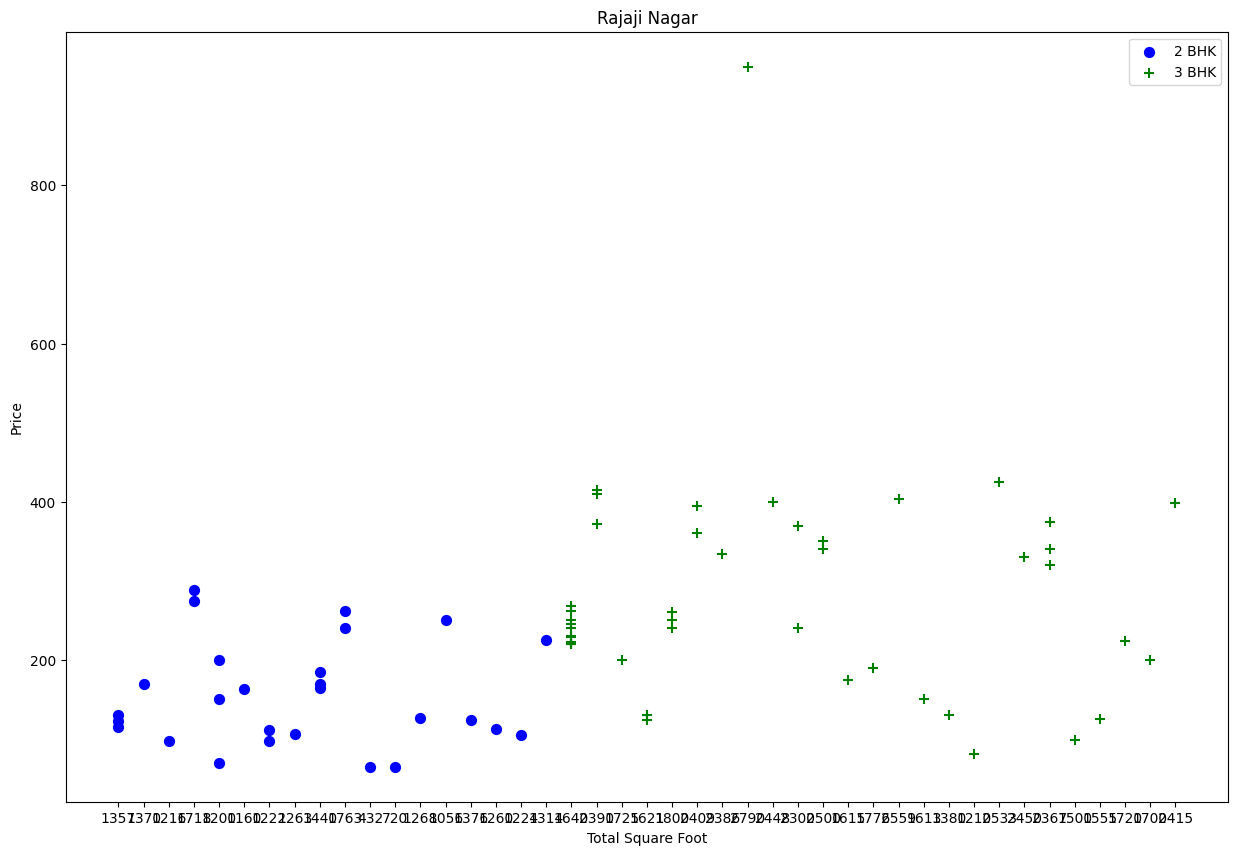

In [45]:
import matplotlib.pyplot as plt
def plot_scatter_chart(df,location):
    bhk2=df[(df.location==location)&(df.bhk==2)]
    bhk3=df[(df.location==location)&(df.bhk==3)]
    plt.rcParams['figure.figsize']=(15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='Blue',label='2 BHK',s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,color='green',marker='+',label='3 BHK',s=50)
    plt.xlabel('Total Square Foot')
    plt.ylabel('Price')
    plt.title(location)
    plt.legend()
plot_scatter_chart(df3,"Rajaji Nagar")

Remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [46]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df)
# df8 = df7.copy()
df8.shape

KeyError: 'location'

Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties

In [52]:
plot_scatter_chart(df8,"Rajaji Nagar")

NameError: name 'df8' is not defined

Based on above charts the data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function

In [ ]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8, color = "brown")
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

#### Outlier Removal Using Bathrooms Feature

In [ ]:
df8.bath.unique()

In [ ]:
plt.hist(df8.bath,rwidth=0.8, color = "burlywood")
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [ ]:
df8[df8.bath>10]

It is unusual to have 2 more bathrooms than number of bedrooms in a home

In [ ]:
df8[df8.bath>df8.bhk+2]

In [ ]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

In [ ]:
df9.head(2)

In [ ]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

#### Use One Hot Encoding For Location

In [ ]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

In [ ]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

In [ ]:
df12 = df11.drop('location',axis='columns')
df12.head(2)

#### Build a Model Now.......

In [ ]:
df12.shape

In [ ]:
X = df12.drop(['price'],axis='columns')
X.head(3)

In [ ]:
X.shape

In [ ]:
y = df12.price
y.head(3)

In [ ]:
len(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [ ]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

#### Use K Fold cross validation to measure accuracy of our LinearRegression model

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

#### Find best model using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
import pandas as pd

def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error', 'friedman_mse'],  # Fixed criterion
                'splitter': ['best', 'random']
            }
        }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

# Call the function
# find_best_model_using_gridsearchcv(X, y)


#### Test the model for few properties

In [ ]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1
  
    return lr_clf.predict([x])[0]

In [ ]:
def predict_price(location, sqft, bath, bhk):
    # Ensure 'sqft', 'bath', 'bhk' are properly passed to this function
    loc_index = np.where(X.columns == location)[0][0]  # Get the index of location column

    # Initialize the feature vector 'x' with zeros, with the same length as the feature set
    x = np.zeros(len(X.columns))

    # Set the values of 'sqft', 'bath', and 'bhk' at the correct indices in 'x'
    x[0] = sqft
    x[1] = bath
    x[2] = bhk

    # Set the encoded location to 1 based on the location index
    if loc_index >= 0:
        x[loc_index] = 1

    # Make prediction using the trained model
    predicted_price = lr_clf.predict([x])[0]

    # Convert np.float64 to Python float
    predicted_price = float(predicted_price)

    return predicted_price  # Return the predicted price


In [ ]:
predict_price('1st Phase JP Nagar',1000, 1, 2)

In [ ]:
predict_price('1st Phase JP Nagar',1450, 4, 4)

In [ ]:
predict_price('Indira Nagar',1000, 2, 2)

In [ ]:
predict_price('Indira Nagar',1500, 5, 5)

In [ ]:
predict_price('Indira Nagar',1500, 9, 5)